<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Resample-first,-then-calculate-velocity" data-toc-modified-id="Resample-first,-then-calculate-velocity-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Resample first, then calculate velocity</a></span></li><li><span><a href="#Calculate-velocity-first,-then-resample" data-toc-modified-id="Calculate-velocity-first,-then-resample-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Calculate velocity first, then resample</a></span></li></ul></div>

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, MeanShift
from sklearn.preprocessing import MinMaxScaler
import psycopg2
from random import choice
import contextily as ctx
import numpy as np
from shapely.geometry import Point, LineString, shape
from tqdm import tqdm_notebook
import numpy as np
from multiprocessing import cpu_count, Pool
from functools import partial
import datetime
from lonelyboy.geospatial import plots as gsplt
from lonelyboy.geospatial import preprocessing as gspp
from lonelyboy.timeseries import lbtimeseries as tspp
import configparser, os

/home/theo/anaconda3/envs/gsa/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/theo/anaconda3/envs/gsa/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/theo/anaconda3/envs/gsa/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
properties = configparser.ConfigParser()
# properties.read(os.path.join('.','sql_server.ini'))
# properties = properties['SERVER']

# host    = properties['host']
# db_name = properties['db_name']
# uname   = properties['uname']
# pw      = properties['pw']
# port    = properties['port']

host    = '195.251.230.8'
db_name = 'doi105281zenodo1167595'
uname   = 'students'
pw      = 'infol@bdbl@bs2017'
port    = '46132'

# ts>1456802710 AND ts<1456975510 

# traj_sql = 'SELECT * FROM ais_data.dynamic_ships WHERE  mmsi=226179000'
traj_sql = 'SELECT * FROM ais_data.dynamic_ships WHERE  ts>1456702710 AND ts<1456975510 '
ports_sql = 'SELECT * FROM ports.ports_of_brittany'

con = psycopg2.connect(database=db_name, user=uname, password=pw, host=host, port = port)
traj = gpd.GeoDataFrame.from_postgis(traj_sql, con, geom_col='geom' )
ports = gpd.GeoDataFrame.from_postgis(ports_sql, con, geom_col='geom' )

con.close()


ports.geom = ports.geom.apply(lambda x: x[0])

In [3]:
traj.head()

,id,mmsi,status,turn,speed,course,heading,lon,lat,ts,geom
0,17490348,234056000,5.0,0.0,0.0,225.0,131,-4.518532,48.367348,1456703339,POINT (-4.518532 48.367348)
1,17490290,227270000,5.0,-127.0,0.0,0.0,511,-4.478298,48.383133,1456702711,POINT (-4.478298 48.383133)
2,17490291,227270000,5.0,-127.0,0.0,0.0,511,-4.478298,48.383133,1456702712,POINT (-4.478298 48.383133)
3,17490292,227148000,5.0,-127.0,0.1,199.4,511,-4.498307,48.380280,1456702712,POINT (-4.4983068 48.38028)
4,17490293,227002330,5.0,0.0,0.0,197.5,149,-4.485922,48.381413,1456702750,POINT (-4.485922 48.381413)


In [39]:
tmp = traj.groupby(['mmsi'])['ts'].apply(lambda x: gspp.get_outliers(x)[0])

In [57]:
tmp = [x for x in tmp if x != []]

In [64]:
len(traj)

612675

In [63]:
gdf.drop([item for sublist in [x for x in gdf.groupby(['mmsi'])['ts'].apply(lambda x: get_outliers(x)[0]) if x != []] for item in sublist], axis=0, inplace=True)

In [72]:
gdf['velocity'], gdf['traj_id'] = np.nan, np.nan

In [73]:
traj

,id,mmsi,status,turn,speed,course,heading,lon,lat,ts,geom,"(test0, test)",test0,test
0,17490348,234056000,10.0,0.0,0.0,225.0,131,-4.518532,48.367348,1456703339,POINT (-4.518532 48.367348),NaN,NaN,NaN
1,17490290,227270000,10.0,-127.0,0.0,0.0,511,-4.478298,48.383133,1456702711,POINT (-4.478298 48.383133),NaN,NaN,NaN
2,17490291,227270000,10.0,-127.0,0.0,0.0,511,-4.478298,48.383133,1456702712,POINT (-4.478298 48.383133),NaN,NaN,NaN
3,17490292,227148000,10.0,-127.0,0.1,199.4,511,-4.498307,48.380280,1456702712,POINT (-4.4983068 48.38028),NaN,NaN,NaN
4,17490293,227002330,10.0,0.0,0.0,197.5,149,-4.485922,48.381413,1456702750,POINT (-4.485922 48.381413),NaN,NaN,NaN
5,17490294,305600000,10.0,0.0,0.1,302.0,214,-4.463332,48.384666,1456702767,POINT (-4.4633317 48.384666),NaN,NaN,NaN
6,17490295,256494000,2.0,0.0,0.0,27.0,53,-4.478515,48.335450,1456702774,POINT (-4.478515 48.33545),NaN,NaN,NaN
8,17490297,234056000,10.0,0.0,0.0,275.6,131,-4.518492,48.367332,1456702798,POINT (-4.5184917 48.367332),NaN,NaN,NaN
9,17490298,228064900,10.0,0.0,0.0,327.4,207,-4.511713,48.364655,1456702805,POINT (-4.5117135 48.364655),NaN,NaN,NaN
10,17490299,227222000,10.0,0.0,0.0,169.6,169,-4.477038,48.382114,1456702821,POINT (-4.4770384 48.382114),NaN,NaN,NaN


In [ ]:
traj

In [17]:
for _, grp in traj.groupby(['mmsi']):
    grp['status'] = grp['status'].apply(lambda x: x*2)

/home/theo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
traj.head()

,id,mmsi,status,turn,speed,course,heading,lon,lat,ts,geom
0,17490348,234056000,5.0,0.0,0.0,225.0,131,-4.518532,48.367348,1456703339,POINT (-4.518532 48.367348)
1,17490290,227270000,5.0,-127.0,0.0,0.0,511,-4.478298,48.383133,1456702711,POINT (-4.478298 48.383133)
2,17490291,227270000,5.0,-127.0,0.0,0.0,511,-4.478298,48.383133,1456702712,POINT (-4.478298 48.383133)
3,17490292,227148000,5.0,-127.0,0.1,199.4,511,-4.498307,48.380280,1456702712,POINT (-4.4983068 48.38028)
4,17490293,227002330,5.0,0.0,0.0,197.5,149,-4.485922,48.381413,1456702750,POINT (-4.485922 48.381413)


In [5]:
lst = [grp[1] for grp in traj.groupby(['mmsi'])]

In [6]:
lst[0]

,id,mmsi,status,turn,speed,course,heading,lon,lat,ts,geom
7608,17498446,209806000,0.0,0.0,10.3,207.9,206,-6.571253,47.920593,1456750117,POINT (-6.5712533 47.920593)


In [7]:
traj.to

In [7]:
start = time()
traj.mmsi.nunique()
time()-start

0.003907203674316406

In [3]:
tmp = gspp.clean_gdf(traj)
tmp = gspp.segment_trajectories(tmp)

/home/theo/anaconda3/envs/gsa/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:1142: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  result = concat(values, axis=self.axis, keys=keys)


Droping 38 rows..


In [4]:
vesss = tmp.loc[tmp.mmsi == 226179000]



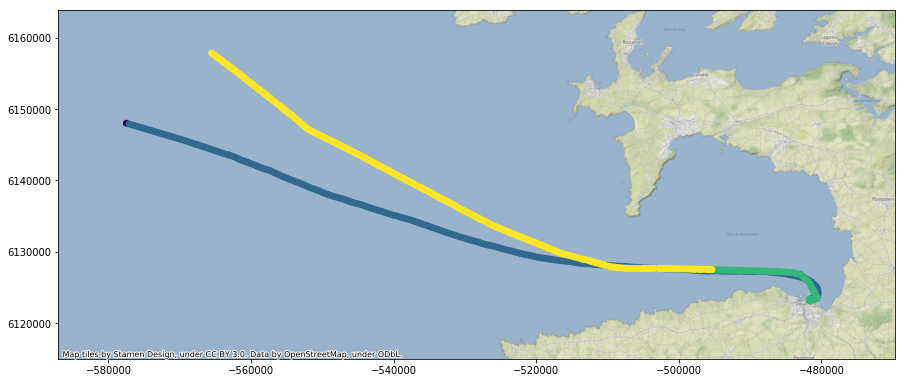

In [5]:
gsplt.map_plot(vesss, column='traj_id')

In [ ]:
resampled_gpd_test = parallelize_dataframe(traj, gspp.clean_gdf, np_split=False, num_partitions=cpu_count())
resampled_gpd_test = parallelize_dataframe(resampled_gpd_test, gspp.segment_trajectories, np_split=False, num_partitions=cpu_count())

In [7]:
sv = traj.loc[traj.mmsi == 226179000]

In [9]:
gspp.segment_trajectories(traj)

/home/theo/Code/lonelyboy/geospatial/preprocessing.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  gdf['current_loc'] = gdf.geom.apply(lambda x: (x.x,x.y))
/home/theo/Code/lonelyboy/geospatial/preprocessing.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  gdf['next_loc'] = gdf.geom.shift(-1)


ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

In [8]:
tmp = traj.copy()

In [5]:
tmp

,course,datetime,geom,heading,lat,lon,mmsi,speed,traj_id,ts,turn,velocity
1,206.000000,2016-02-29 00:48:00,POINT (-6.5178785 47.992603),195.000000,47.992603,-6.517879,210446000.0,9.300000,-1.0,1456706880,127.000000,10.566417
2,206.024762,2016-02-29 00:49:00,POINT (-6.519593070476191 47.99023754285714),195.076190,47.990238,-6.519593,210446000.0,9.299048,0.0,1456706940,124.590476,10.566417
3,206.049524,2016-02-29 00:50:00,POINT (-6.521307640952381 47.98787208571429),195.152381,47.987872,-6.521308,210446000.0,9.298095,0.0,1456707000,122.180952,10.566417
4,206.074286,2016-02-29 00:51:00,POINT (-6.523022211428572 47.98550662857143),195.228571,47.985507,-6.523022,210446000.0,9.297143,0.0,1456707060,119.771429,10.566417
5,206.099048,2016-02-29 00:52:00,POINT (-6.524736781904762 47.98314117142857),195.304762,47.983141,-6.524737,210446000.0,9.296190,0.0,1456707120,117.361905,10.566417
6,206.123810,2016-02-29 00:53:00,POINT (-6.526451352380953 47.98077571428572),195.380952,47.980776,-6.526451,210446000.0,9.295238,0.0,1456707180,114.952381,10.566417
7,206.148571,2016-02-29 00:54:00,POINT (-6.528165922857143 47.97841025714286),195.457143,47.978410,-6.528166,210446000.0,9.294286,0.0,1456707240,112.542857,10.566417
8,206.173333,2016-02-29 00:55:00,POINT (-6.529880493333334 47.9760448),195.533333,47.976045,-6.529880,210446000.0,9.293333,0.0,1456707300,110.133333,10.566417
9,206.198095,2016-02-29 00:56:00,POINT (-6.531595063809524 47.97367934285715),195.609524,47.973679,-6.531595,210446000.0,9.292381,0.0,1456707360,107.723810,10.566417
10,206.222857,2016-02-29 00:57:00,POINT (-6.533309634285715 47.97131388571429),195.685714,47.971314,-6.533310,210446000.0,9.291429,0.0,1456707420,105.314286,10.566417


In [3]:
def partition_geospatial(gdf, feature='mmsi', num_partitions=1):
    partitions = []
    
    tmp_X = gpd.GeoDataFrame([], columns=gdf.columns)
    for _, x in gdf.groupby([feature]):
        tmp_X = tmp_X.append(x)
        if len(tmp_X) >= len(gdf)//num_partitions:
            partitions.append(tmp_X.reset_index(drop=True))
            tmp_X = tmp_X.iloc[0:0] # Drop all Rows
    partitions.append(tmp_X.reset_index(drop=True))
    return partitions


def parallelize_dataframe(df, func, np_split=True, feature='mmsi', num_partitions=1):
    if np_split:
        partitions = np.array_split(df, cpu_count())
    else:
        partitions = partition_geospatial(df, feature, num_partitions)
        
    pool = Pool(num_partitions)
    df = pd.concat(pool.map(func, partitions))
    pool.close()
    pool.join()
    return df

In [18]:
tmp = partition_geospatial(traj, num_partitions=cpu_count())

In [4]:
%time resampled_gpd_test = parallelize_dataframe(traj, gspp.segment_trajectories, np_split=False, num_partitions=cpu_count())

/home/theo/Code/lonelyboy/geospatial/preprocessing.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  vessel.drop_duplicates(['ts', 'mmsi'], inplace=True)
/home/theo/Code/lonelyboy/geospatial/preprocessing.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  gdf['current_loc'] = gdf.geom.apply(lambda x: (x.x,x.y))
/home/theo/Code/lonelyboy/geospatial/preprocessing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

/home/theo/Code/lonelyboy/geospatial/preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  gdf['next_loc'] = gdf.next_loc.apply(lambda x : (x.x,x.y))
/home/theo/Code/lonelyboy/geospatial/preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  gdf['next_loc'] = gdf.next_loc.apply(lambda x : (x.x,x.y))
/home/theo/Code/lonelyboy/geospatial/preprocessing.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

CPU times: user 15.6 s, sys: 244 ms, total: 15.8 s
Wall time: 1min 40s


In [11]:
tmp = gspp.resample_geospatial(traj)

In [5]:
traj

,id,mmsi,status,turn,speed,course,heading,lon,lat,ts,geom
0,17490290,227270000,5.0,-127.0,0.0,0.0,511,-4.478298,48.383133,1456702711,POINT (-4.478298 48.383133)
1,17490348,234056000,5.0,0.0,0.0,225.0,131,-4.518532,48.367348,1456703339,POINT (-4.518532 48.367348)
2,17490349,234056000,5.0,0.0,0.0,225.0,131,-4.518532,48.367348,1456703339,POINT (-4.518532 48.367348)
3,17490350,228064900,5.0,0.0,0.0,327.4,207,-4.511734,48.364700,1456703345,POINT (-4.5117335 48.3647)
4,17490351,227222000,5.0,0.0,0.0,169.0,169,-4.477032,48.382120,1456703361,POINT (-4.4770317 48.38212)
5,17490352,220417000,5.0,-6.0,0.0,118.7,36,-4.453505,48.383648,1456703400,POINT (-4.453505 48.383648)
6,17490353,412069000,5.0,0.0,0.0,36.9,262,-4.467605,48.380867,1456703419,POINT (-4.467605 48.380867)
7,17490354,636015033,1.0,0.0,0.1,281.2,97,-4.522513,48.330894,1456703420,POINT (-4.5225134 48.330894)
8,17490355,226263000,5.0,0.0,0.0,256.2,134,-4.485792,48.379810,1456703428,POINT (-4.4857917 48.37981)
9,17490356,249297000,5.0,0.0,0.0,29.0,215,-4.454518,48.385006,1456703429,POINT (-4.4545183 48.385006)


In [7]:
lst = [grp[1] for grp in traj.groupby(['mmsi'])]

In [ ]:
len(lst)

In [4]:
# traj = pd.read_csv('data/updated_ais.csv', index_col=0)
# traj.geom = traj[['lon', 'lat']].apply(lambda x: Point(x[0],x[1]), axis=1)
# traj = gpd.GeoDataFrame(traj, geometry='geom')
# traj.drop_duplicates(['ts','mmsi'], inplace=True)

In [7]:
sample_ves = traj.loc[traj.mmsi == 226179000]
sample_ves.drop_duplicates(['ts'], inplace=True)
clean_sv = sample_ves.drop(gspp.get_outliers(sample_ves.ts, alpha=3)[0], axis=0)
print (len(sample_ves)- len(clean_sv))
clean_sv.sort_values(['ts'], inplace=True)
clean_sv.reset_index(inplace=True)
clean_sv.drop(['index','id', 'status'], axis=1, inplace=True)

0


/home/theo/anaconda3/envs/gsa/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


KeyError: "['id' 'status'] not found in axis"

# Resample first, then calculate velocity

In [8]:
tmp = gspp.resample_geospatial(clean_sv)

In [9]:
resvel = gspp.calculate_velocity(tmp, smoothing=True, window=3)

/home/theo/Code/lonelyboy/geospatial/preprocessing.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  gdf['next_loc'] = gdf.next_loc.apply(lambda x : (x.x,x.y))
/home/theo/Code/lonelyboy/geospatial/preprocessing.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  gdf['velocity'] = gdf[['current_loc', 'next_loc']].apply(lambda x : haversine(x[0], x[1])*0.539956803 , axis=1).multiply(3600/gdf.ts.diff(-1).abs())
/home/theo/Code/lonelyboy/geospatial/preprocessing.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [10]:
resvel = resvel.drop(gspp.get_outliers(resvel.velocity, alpha=3)[0], axis=0)

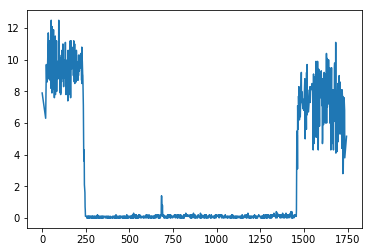

In [13]:
resvel.speed.plot()

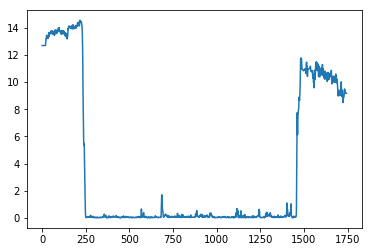

In [14]:
resvel.velocity.plot()

# Calculate velocity first, then resample

In [15]:
velres = gspp.calculate_velocity(clean_sv, smoothing=True, window=3)

In [16]:
velres = gspp.resample_geospatial(velres)

In [17]:
velres = velres.drop(gspp.get_outliers(velres.velocity, alpha=3)[0], axis=0)

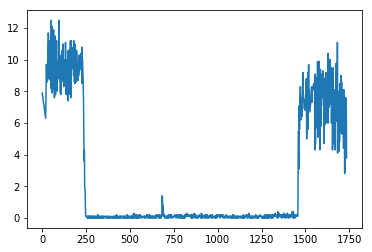

In [18]:
velres.speed.plot()

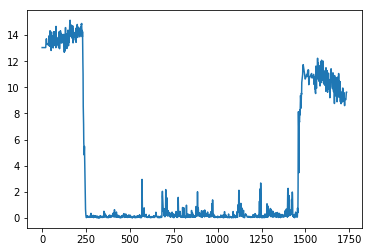

In [19]:
velres.velocity.plot()

In [20]:
pois, (q_low, qhigh) = gspp.detect_POIs(tmp, alpha=20, window=100)

In [70]:
diff_series = tmp.velocity.rolling(100).mean().diff().rolling(100).mean()
#detect the outliers of the above series.
outlier_groups = gspp.get_outliers(diff_series.dropna(), alpha=20)

pois = [poi for poi in outlier_groups]

In [70]:
pois,(ql,qh) = gspp.detect_POIs(velres, alpha=80, window=100)

In [21]:
# plt.axvline(x=min(outs), c='r')
# plt.axvline(x=outs[0], c='r')

plt.axhline(y=qh, c='g')
plt.axhline(y=ql, c='g')

# for poi in pois:
#     if 14374>poi>14056:
#         plt.axvline(x=poi, c='r')


# plt.savefig('poifig.png')
# gsplt.plot_segments(tmp, feature='slope',alpha=3)

diff_series = velres.velocity.rolling(100).mean().diff().rolling(100).mean()
diff_series[:50000].plot(figsize=(25,5), c='red')
plt.savefig('diffs.png')

NameError: name 'qh' is not defined

11


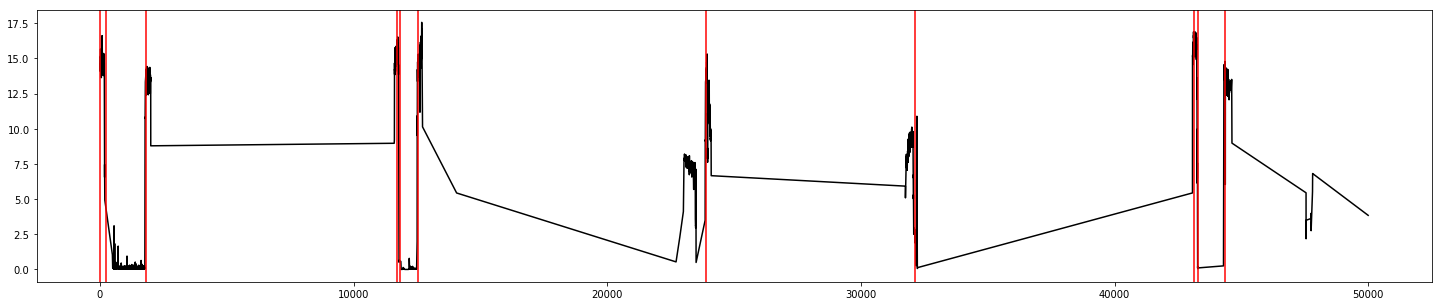

In [147]:
velres[:50000].velocity.plot(figsize=(25,5), c=(0,0,0))
cnt = 0
for poi in pois:
    if poi<50000:
        plt.axvline(x=poi, c='r')
        cnt += 1
        
print (cnt)
plt.savefig('velocitysplit.png')

In [23]:
def get_trajetory_segment(x, pois):
    for poi in pois:
        if x.name >= poi:
            continue
        return int(pois.index(poi)-1)

In [24]:
velres['traj_id'] = velres.apply(get_trajetory_segment , args=(pois,), axis=1)

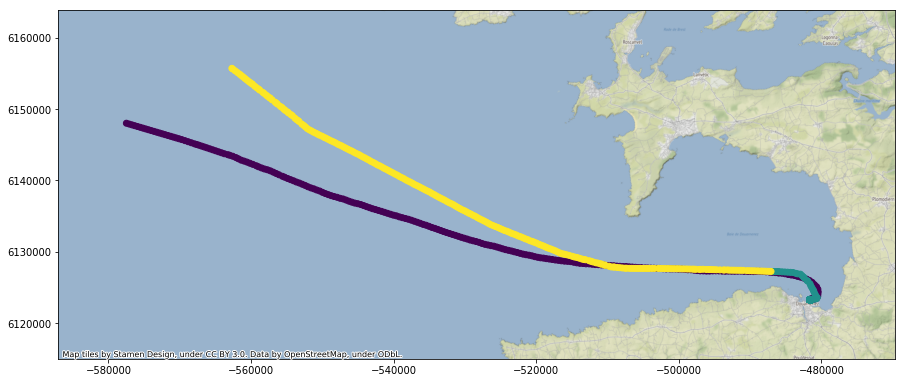

In [26]:
gsplt.map_plot(velres, column='traj_id')

In [121]:
def parallelize_dataframe(df, func):
    df_split = np.array_split(df, cpu_count())
    pool = Pool(cpu_count())
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [126]:
def multiply_columns(data):
    data['traj_id'] = data.apply(get_trajetory_segment , args=(pois,), axis=1)
    return velres

In [128]:
velres = multiply_columns(velres)

In [133]:
velres[:50000]

,mmsi,turn,speed,course,heading,lon,lat,ts,geom,datetime,velocity,traj_id
0,226179000.0,-127.0,10.400000,102.800000,511.0,-5.030692,48.093006,1.444081e+09,POINT (-5.0306916 48.093006),2015-10-05 21:32:00,14.432103,0.0
1,226179000.0,-127.0,10.200000,95.433333,511.0,-5.026736,48.092971,1.444081e+09,POINT (-5.026736066666667 48.09297066666667),2015-10-05 21:33:00,14.432103,0.0
2,226179000.0,-127.0,10.000000,88.066667,511.0,-5.022781,48.092935,1.444081e+09,POINT (-5.022780533333333 48.09293533333334),2015-10-05 21:34:00,14.432103,0.0
3,226179000.0,-127.0,9.800000,80.700000,511.0,-5.018825,48.092900,1.444081e+09,POINT (-5.018825 48.0929),2015-10-05 21:35:00,14.432103,0.0
4,226179000.0,-127.0,9.000000,89.400000,511.0,-5.017485,48.092860,1.444081e+09,POINT (-5.017485 48.09286),2015-10-05 21:36:00,14.432103,0.0
5,226179000.0,-127.0,9.650000,86.050000,511.0,-5.011760,48.092851,1.444081e+09,POINT (-5.01176 48.092851),2015-10-05 21:37:00,14.496272,0.0
6,226179000.0,-127.0,10.300000,82.700000,511.0,-5.006035,48.092842,1.444081e+09,POINT (-5.006035 48.092842),2015-10-05 21:38:00,14.560442,0.0
7,226179000.0,-127.0,9.500000,74.700000,511.0,-5.003260,48.092920,1.444081e+09,POINT (-5.00326 48.09292),2015-10-05 21:39:00,14.570557,0.0
8,226179000.0,-127.0,10.000000,98.600000,511.0,-5.001290,48.093000,1.444081e+09,POINT (-5.00129 48.093),2015-10-05 21:40:00,14.335582,0.0
9,226179000.0,-127.0,9.900000,75.300000,511.0,-4.996760,48.093147,1.444081e+09,POINT (-4.99676 48.093147),2015-10-05 21:41:00,14.157782,0.0


In [137]:
velres.iloc[:50000].traj_id.unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

In [134]:
LABEL_COLOR_MAP = {0 : 'black', 1 : 'r', 2 : 'g',\
                   3 : 'b', 4 : 'm', 5 : 'y', 6 : 'maroon', 7 : 'pink',\
                   8 : 'sienna', 9 : 'darkslategray', 10 : 'purple', 
                   11 : 'darkgoldenrod', 12: 'chocolate'}

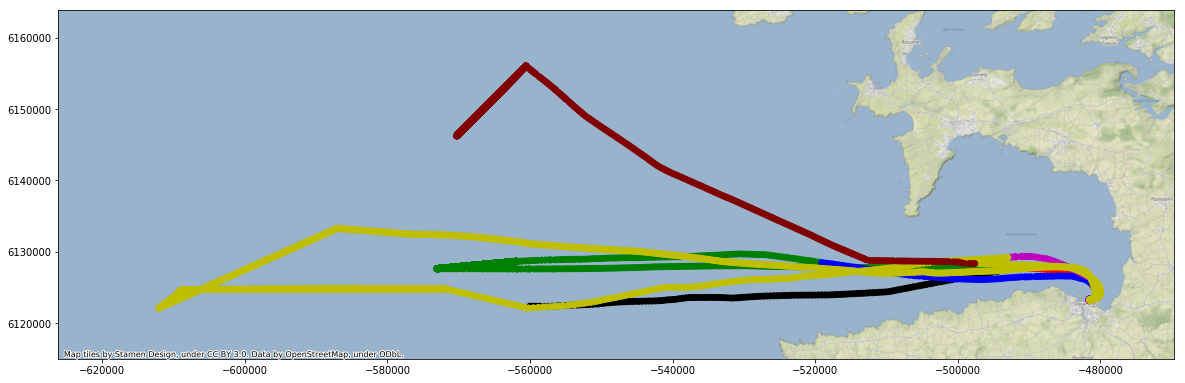

In [145]:
velres.crs = {'init': 'epsg:4326'}
color = [LABEL_COLOR_MAP[int(i)] for i in velres[:30000].traj_id]
ax = velres[:30000].to_crs(epsg=3857).plot(figsize=fsize,c=color)
ctx.add_basemap(ax)
plt.savefig('trajonmap.png')

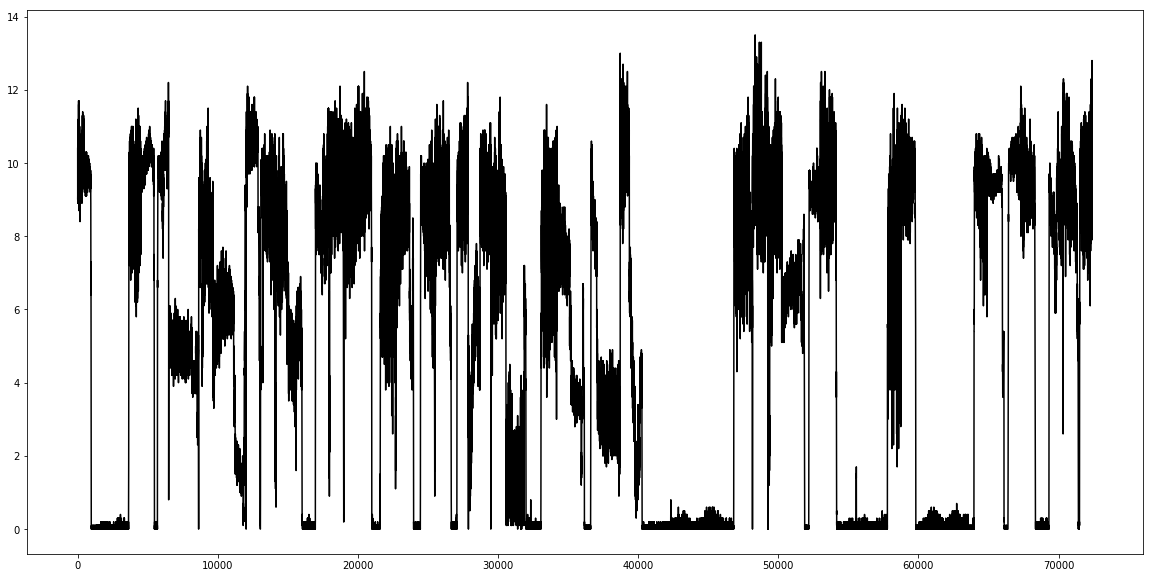

In [37]:
# plt.axvline(x=min(outs), c='r')
# plt.axvline(x=outs[0], c='r')
tmp.speed.plot(figsize=(20,10), c=(0,0,0))
# for poi in pois:
# #     if poi>5000: break
#     plt.axvline(x=poi, c='r')
    


# plt.savefig('poifig.png')
# gsplt.plot_segments(tmp, feature='slope',alpha=3)

In [12]:
(tmp.iloc[4999].ts - tmp.iloc[0].ts )/ (3600*24)

8.122800925925926

In [46]:
diffs = tmp[:5000]['velocity'].rolling(100).mean().diff().rolling(100).mean()

In [50]:
outlier_groups = gspp.get_outliers(diffs.dropna(), alpha=20)

In [51]:
for ind, point in enumerate(outlier_groups[1:],1):
    if point != outlier_groups[ind-1]+1:
        pois.append(point)

In [52]:
# for _, df in tqdm_notebook(traj.groupby('mmsi')):
pois

[0,
 199,
 489,
 11600,
 14056,
 22712,
 23859,
 31754,
 43072,
 44295,
 47550,
 51581,
 53238,
 55881,
 57376,
 60396,
 62016,
 71933,
 83103,
 89804,
 93959,
 100770,
 103800,
 104411,
 107049,
 119280,
 134711,
 141923,
 152874,
 161571,
 174515,
 184936,
 189278,
 193766,
 204765,
 213006,
 222984,
 234996,
 245180,
 247558,
 252566,
 252841]

In [9]:
for i in range(len(pois)-1):
    print(tmp.iloc[pois[i]].velocity - tmp.iloc[pois[i+1]].velocity)

13.351225314
-10.6627534594
1.64833855736


In [16]:
pois

[0, 242, 1468, 1709]

In [10]:
tmp.head()

,mmsi,turn,speed,course,heading,lon,lat,ts,geom,d2np,datetime,velocity
0,226179000.0,-127.0,9.700000,111.600000,511.0,-5.101860,48.229477,1.456863e+09,POINT (-5.10186 48.229477),0.220861,2016-03-01 20:02:00,13.399195
1,226179000.0,-127.0,9.250000,105.050000,511.0,-5.099131,48.228914,1.456863e+09,POINT (-5.09913085 48.2289135),0.219537,2016-03-01 20:03:00,13.399195
2,226179000.0,-127.0,8.800000,98.500000,511.0,-5.096402,48.228350,1.456863e+09,POINT (-5.0964017 48.22835),0.218214,2016-03-01 20:04:00,13.399195
3,226179000.0,-127.0,8.836364,99.845455,511.0,-5.092571,48.227519,1.456863e+09,POINT (-5.092571090909091 48.22751854545454),0.216760,2016-03-01 20:05:00,13.399195
4,226179000.0,-127.0,8.872727,101.190909,511.0,-5.088740,48.226687,1.456863e+09,POINT (-5.088740481818182 48.22668709090909),0.215306,2016-03-01 20:06:00,13.399195
